# Ridgeless least square 

In [1]:
from sklearn.base import RegressorMixin
from scipy.stats import ortho_group # orthogonal matrix

import numpy as np
import math

import os
import json, codecs

import scienceplots
import seaborn as sns
import matplotlib.pyplot as plt

from joblib import Parallel, delayed

# Sketched estimator


In [2]:
class RidgelessLinearRegressor(RegressorMixin):
    """Ridgeless linear regression using Moore Penrose pseudoinverse."""

    def __init__(self):
        self.beta = None

    def fit(self, x, y):
        n = x.shape[0]
        p = x.shape[1]
        
        #xxinv = np.linalg.pinv(np.matmul(x.T, x))
        #xy = np.matmul(x.T, y)
        
        Ip = np.eye(p)
        xxinv = np.linalg.inv(np.matmul(x.T, x)/n + 1e-9 * Ip)
        xy = np.matmul(x.T, y)/n
        
        self.beta = np.matmul(xxinv, xy)
        return self

    def predict(self, x):
        return np.matmul(x, self.beta)

# Data generation

- Assumption 2.2, $\beta \sim \mathcal{N}_p\left(0, \frac{\alpha^2}{p} I_p\right)$, where $||\beta||^2_2 \to \alpha^2$, independent of the data matrix $X$, noise $\epsilon$, sketching matrix $S$
- Assumption 2.1, for $i = 1, \dots, n$, $x_i = \Sigma^{1/2} z_i$ where $z_i$ iid components with mean 0 and variance 1 and finite 4-th moment; $\epsilon \perp X$, $E[\epsilon]=0, Var(\epsilon)=\sigma^2$


In [7]:
def gen_train_dat(n_train, n_features, alpha, sigma, seed):
    """
    n_samples: n
    n_features: p
    alpha: beta's norm
    sigma: sigma
    """

    #bet = norm / np.sqrt(p) * np.ones(p) 
    
    # seed for fixed X
    np.random.seed(1234)

    # Assumption 2.1 (model specification)
    x = np.random.normal(size=(n_train, n_features), scale=1)
    
    # seed for eps, beta
    np.random.seed(seed+3524)
    
    # Assumption 2.2 (random beta)
    bet = alpha / np.sqrt(n_features) * np.random.normal(size=n_features)  #from guassian prior
    eps = np.random.normal(size=n_train, scale=sigma)
    y = np.matmul(x, bet) + eps

    return x, y, bet

In [8]:
def gen_test_dat(n_test, n_features, beta, sigma, seed):
    
    # seed for x0 and eps
    np.random.seed(seed+1234)
    
    x0 = np.random.normal(size=(n_test, n_features), scale=1)
    eps = np.random.normal(size=n_test, scale=sigma)
    y = np.matmul(x0, beta) + eps

    return x0, y

# Theorem 

In [9]:
def asy_risk(n, p, alpha, sigma):

    phi = p / n

    # gamma < 1
    r_up = sigma**2 * phi / (1 - phi)

    # gamma > 1
    r_op = alpha**2 * (1 - 1/phi) + sigma**2 / (phi - 1)

    return (phi < 1) * r_up + (phi > 1) * r_op

## Simulation

In [10]:
def simulate(n_train, n_features, alpha, sigma, seed, is_orthogonal=True, n_test=1):
    
    # train
    x, y, beta = gen_train_dat(n_train, n_features, alpha, sigma, seed)  

    # test
    x_oos, y_oos = gen_test_dat(n_test, n_features, beta, sigma, seed)

    # fit ridgeless least square
    ridgeless = RidgelessLinearRegressor()
    ridgeless = ridgeless.fit(x, y)
    
    # calculate mse
    test_mse = np.mean((np.matmul(x_oos, ridgeless.beta) - np.matmul(x_oos, beta))**2)

    return test_mse

In [25]:
n_train = 400
n_test = 100

alpha = 10
sigma = 5
seed = 12341234
n_sim = 500

n_pts = 20                 # number of points in the graph for visualizing empirical results (dots)
n_pts_asymp = 100          # number of points in the graph for visualizing theorem 3.2 (line)

In [26]:
%%time
pp = np.zeros(n_pts, dtype=int)
mse_original = np.zeros(n_pts)

phi_range = list(np.logspace(-1, 1, n_pts))
for i, pphi in enumerate(phi_range):
    pp[i] = int(pphi * n_train)

    # Non-sketching
    mse_oos = []
    mse_oos = Parallel(n_jobs=-1)(delayed(simulate)(n_train, pp[i], alpha, sigma, seed+j, n_test=n_test) for j in range(n_sim))

    mse_original[i] = np.mean(mse_oos)

CPU times: user 21.6 s, sys: 1.54 s, total: 23.1 s
Wall time: 15min 5s


In [27]:
# Theoretical
pp = np.zeros(n_pts_asymp, dtype=int)
mse_asy = np.zeros(n_pts_asymp)

phi = list(np.logspace(-1, 1, n_pts_asymp))
for i, pphi in enumerate(phi):
    pp[i] = int(pphi * n_train)
    mse_asy[i] = asy_risk(n_train, pp[i], alpha, sigma)

In [28]:
data = {
    "n_train": n_train,
    "alpha": alpha,
    "sigma": sigma,
    "seed": seed,
    "emp_psi": phi_range,
    "emp_risk": mse_original.tolist(),
    "psi": phi,
    "risk": mse_asy.tolist()
}

In [29]:
import os

save_path = "../result/ridgeless/" 
if not os.path.isdir(save_path):
    os.makedirs(save_path)

In [30]:
# Save
with open(save_path + 'SNR' + str(np.round(alpha/sigma,2)) + '_nsim' + str(n_sim) + '.json', 'w') as file:
    json.dump(data, file,indent=4)

In [62]:
# # Load
# file = json.loads(codecs.open(save_path + 'alpha' + str(alpha) + '_nsim' + str(n_sim) + '.json', 'r').read())

## Summary


In [2]:
def load_files(file_loc):
    file = json.loads(codecs.open('../result/' + file_loc, 'r').read())
    emp_psi = file["emp_psi"]
    emp_risk = file["emp_risk"]

    psi = file["psi"]
    risk = file["risk"]

    return file["alpha"]/file["sigma"], emp_psi, emp_risk, psi, risk

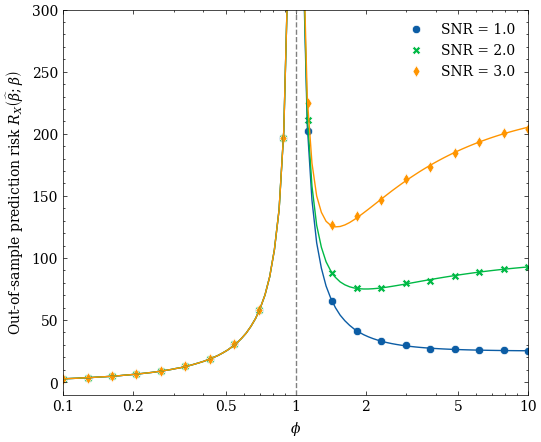

In [4]:
# Plot
ticks = [0.1, 0.2, 0.5, 1, 2, 5, 10]
labels = [i for i in ticks]

with plt.style.context(['science', 'no-latex', 'std-colors']):
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))

    snr, emp_psi, emp_risk, psi, risk = load_files('ridgeless/SNR1.0_nsim500.json')
    ax = sns.scatterplot(x=emp_psi, y=emp_risk, label = "SNR = " + str(np.round(snr, 2)))
    ax = sns.lineplot(x=psi, y=risk)

    snr, emp_psi, emp_risk, psi, risk = load_files('ridgeless/SNR2.0_nsim500.json')
    ax = sns.scatterplot(x=emp_psi, y=emp_risk, marker='X', label = "SNR = " + str(np.round(snr, 2)))
    ax = sns.lineplot(x=psi, y=risk)

    snr, emp_psi, emp_risk, psi, risk = load_files('ridgeless/SNR3.0_nsim500.json')
    ax = sns.scatterplot(x=emp_psi, y=emp_risk, marker = 'd', label = "SNR = " + str(np.round(snr, 2)))
    ax = sns.lineplot(x=psi, y=risk)
    
    # snr, emp_psi, emp_risk, psi, risk = load_files('surprise_ridgeless/SNR2.24_nsim500.json')
    # ax = sns.scatterplot(x=emp_psi, color="darkred", y=emp_risk)
    # ax = sns.lineplot(x=psi, y=risk, color="darkred", label = "SNR = " + str(np.round(snr, 2)))

    ax.set_ylim(-10, 300)
    ax.set_xlim(0.1, 10)
    ax.axvline(x=1, color="grey", linestyle='dashed', linewidth=1)
    ax.set_xscale('log')
    ax.set(xticks = ticks, xticklabels = labels)
    #ax.set_title("Isotropic features")

    ax.set_ylabel(r"Out-of-sample prediction risk $R_{X}\left(\widehat{\beta} ; \beta\right)$")
    ax.set_xlabel(r"$\phi$")

    plt.savefig('figure0.pdf', dpi=400, facecolor='w', edgecolor='w', pad_inches=None)
    plt.show()

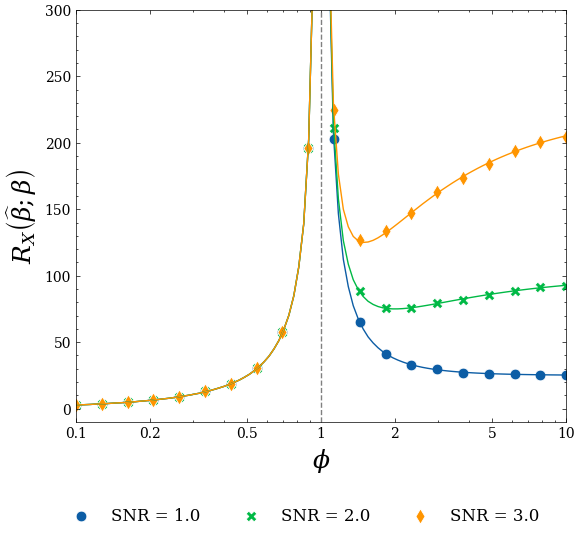

In [5]:
# Plot
ticks = [0.1, 0.2, 0.5, 1, 2, 5, 10]
labels = [i for i in ticks]

with plt.style.context(['science', 'no-latex', 'std-colors']):
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))

    snr, emp_psi, emp_risk, psi, risk = load_files('ridgeless/SNR1.0_nsim500.json')
    ax = sns.scatterplot(x=emp_psi, y=emp_risk, s=60, label = "SNR = " + str(np.round(snr, 2)))
    ax = sns.lineplot(x=psi, y=risk)

    snr, emp_psi, emp_risk, psi, risk = load_files('ridgeless/SNR2.0_nsim500.json')
    ax = sns.scatterplot(x=emp_psi, y=emp_risk, marker='X', s=60, label = "SNR = " + str(np.round(snr, 2)))
    ax = sns.lineplot(x=psi, y=risk)

    snr, emp_psi, emp_risk, psi, risk = load_files('ridgeless/SNR3.0_nsim500.json')
    ax = sns.scatterplot(x=emp_psi, y=emp_risk, marker = 'd', s=60, label = "SNR = " + str(np.round(snr, 2)))
    ax = sns.lineplot(x=psi, y=risk)
    
    # snr, emp_psi, emp_risk, psi, risk = load_files('surprise_ridgeless/SNR2.24_nsim500.json')
    # ax = sns.scatterplot(x=emp_psi, color="darkred", y=emp_risk)
    # ax = sns.lineplot(x=psi, y=risk, color="darkred", label = "SNR = " + str(np.round(snr, 2)))

    ax.set_ylim(-10, 300)
    ax.set_xlim(0.1, 9.99)
    ax.axvline(x=1, color="grey", linestyle='dashed', linewidth=1)
    ax.set_xscale('log')
    ax.set(xticks = ticks, xticklabels = labels)
    #ax.set_title("Isotropic features")

    ax.set_ylabel(r"$R_{X}\left(\widehat{\beta} ; \beta\right)$", fontsize=18)
    ax.set_xlabel(r"$\phi$", fontsize=18)

    ax.get_legend().remove()
    handles, labels = ax.get_legend_handles_labels()
 
    #handles, labels = ax[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.52, -0.1), ncol = 4, prop={'size':12})
    plt.tight_layout()


    plt.savefig('figure0.pdf', dpi=400, facecolor='w', edgecolor='w', pad_inches=None)
    plt.show()